In [1]:
#this note book check if tcax.z.hat provides additional info on top of W, X
#fits a model:  Z_jh ~ W_h + X_j + Z_jh.tcax across i, for all i, h on the sc-stephenson data 

In [2]:
library("MASS")
library("testit")
library("pracma")
library("data.table")
library("matrixStats")
#library("compositions")

source("analysis.utils.r")
source("simulate.expression.utils.r")

library("ggplot2")
library("ggpubr")
library("grid")
library("tidyr")
library("scales")
library("latex2exp")
library("hrbrthemes")
library("extrafont")
#library("ggpointdensity")

Warning message:
“package ‘MASS’ was built under R version 4.1.3”
Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: ‘compositions’


The following objects are masked from ‘package:stats’:

    anova, cor, cov, dist, var


The following objects are masked from ‘package:base’:

    %*%, norm, scale, scale.default


NOTE: Either Arial Narrow or Roboto Condensed fonts are required to use these themes.

      Please use hrbrthemes::import_roboto_condensed() to install Roboto Condensed and

      if Arial Narrow is not on your system, please see https://bit.ly/arialnarrow

Registering fonts with R



In [3]:
#log.p.vals.mats: list of matrix. names are the source.ids, each matrix is features by some columns. each entry is a p val
#var.to.plt: character. column name in log.p.vals.mat of the variable to plot 
#source.ids: list of character. source to show
#visualize each source.id as a figure. different source.id will be shown as different panel. 
#each panel's x axis are features. y axis is negtive log pval
manplot = function(log.p.vals.mats, var.to.plt, source.ids){
    k = length(log.p.vals.mats)
    plts<- lapply(1:k, function(h){
        source.id = source.ids[h]
        df = as.data.frame(log.p.vals.mats[[source.id]])
        df[df>300] = 300
        df$j = 1:nrow(log.p.vals.mats[[source.id]]) 
        g = ggplot(df, aes(x = j, y = df[,var.to.plt])) +
            geom_point(alpha = 1, size = 1) + 
            ggtitle(paste0(source.id)) +  
            theme(plot.title = element_text(hjust = 0.5, size = 15))+ theme(text=element_text(size=15))+ 
            ylab("negative log10 p val") +
            #clean background 
            theme(panel.grid.major = element_blank(), 
                  panel.grid.minor = element_blank(),
                  panel.background = element_blank(), 
                  axis.title.x = element_blank(),
                  axis.line = element_line(colour = "black"))
        return(g)
    })
    return (egg::ggarrange(plots = plts, align = "h", widths = rep(1, k))) 

}

In [4]:
#old
get_log_p_vals_mats = function(X, W, Z, Z.hat, num.stds = 2, constant_thr = 0.001){
# for each gene fit a joint model and reported the p-val on each terms
# per gene the outliers defined by the num.stds are removed
    res = list()
    for (source.id in colnames(W)){
            print(paste0("working on ", source.id))
        p.vals.mat  = list()
        for (j in 1:nrow(X)){
                constant.flag = F

            df = data.frame(Z.hat = Z.hat[source.id,j,], bulk = X[j, ], Z = Z[source.id,j,])
            df = cbind(df, W)

            x = X[j, ]
            mask = abs(x - mean(x)) <= num.stds * sd(x)
            df = df[mask, ]

            if(sd(df$Z.hat) <= constant_thr){
                #if no variance detected in celltype h, gene j, 
                #sample from random normal with same mean but variance 1
                df = df[, -1]
                constant.flag = T
            }

            # #not neccesary  #Column standardize
            #df = as.matrix(df[mask, ])
            #df = df/repmat(t(as.matrix(colSds(as.matrix(df)))),nrow(df),1 )
            #df = as.data.frame(df)

            fit = lm(formula = Z ~ 0 + ., data = df) # no intercept because W already co-linear 
            p.vals.mat[[j]] = t(summary(fit)$coefficients)["Pr(>|t|)", , drop = F]
            if(constant.flag){
                #put p = 1 
                Z.hat.p = matrix(1, 1, 1)
                colnames(Z.hat.p) = c("Z.hat")
                p.vals.mat[[j]] = cbind(Z.hat.p,p.vals.mat[[j]])
            }
        }
        p.vals.mat = Reduce(rbind, p.vals.mat)
        rownames(p.vals.mat) = rownames(X)
        res[[source.id]] = -log10(p.vals.mat)
    }
    return (res)
}

In [5]:
data.dir       = "../Data/RNA/Simulation-Lung/sc-HLCA_all.W_k_4_m_600_n_500_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0.85_enrich_T_etpRat_0.625_enrichRat_0.25_maxSds_3_scale.maxSds_Inf_scale.factor.thr_1e-04/"
res.dir        = "../Result/RNA/Simulation-Lung/sc-HLCA_all.W_k_4_m_600_n_500_dirichlet_F_noiseZ_T_varThr_1e-04_filThr_1e-04_expQtl_0.85_enrich_T_etpRat_0.625_enrichRat_0.25_maxSds_3_scale.maxSds_Inf_scale.factor.thr_1e-04/"

base.mdl.list       = readRDS(file.path(res.dir,"base.mdl.list.rds"))
cibersortx.mdl.list = readRDS(file.path(res.dir,"cibersortx.mdl.list.rds"))
tca.mdl.list        = readRDS(file.path(res.dir,"tca.mdl.list.rds"))
tcax.mdl.list       = readRDS(file.path(res.dir,"tcax.mdl.mp_0_vp_0.01_cp_0.01.list.rds"))

In [6]:
ts = 1:20
sim.data.list = list()  
for (t in ts){
    sim.data.list[[t]] = readRDS(file.path(data.dir,paste0("sim.data.rds.", t)))
   
}

In [7]:
sim.data = sim.data.list[[1]]
k = ncol(sim.data$W)
m = nrow(sim.data$X)
n = ncol(sim.data$X)
source.ids = colnames(sim.data$W)

In [8]:
cibersortx.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X.scale,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z.scale,
                                      Z.hat = cibersortx.mdl.list[[1]]$Z.hat.eval,
                                      num.stds = 2)

base.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X.scale,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z.scale,
                                      Z.hat = base.mdl.list[[1]]$Z.hat.eval,
                                      num.stds = 2)

tca.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X.scale,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z.scale,
                                      Z.hat = tca.mdl.list[[1]]$Z.hat.eval,
                                      num.stds = 2)

tcax.log.p.vals.mats = get_log_p_vals_mats(X = sim.data.list[[1]]$X.scale,
                                      W = sim.data.list[[1]]$W,
                                      Z = sim.data.list[[1]]$Z.scale,
                                      Z.hat = tcax.mdl.list[[1]]$Z.hat.eval,
                                      num.stds = 2)

[1] "working on Immune"
[1] "working on Epithelial"
[1] "working on Endothelial"
[1] "working on Stroma"


# Manplot

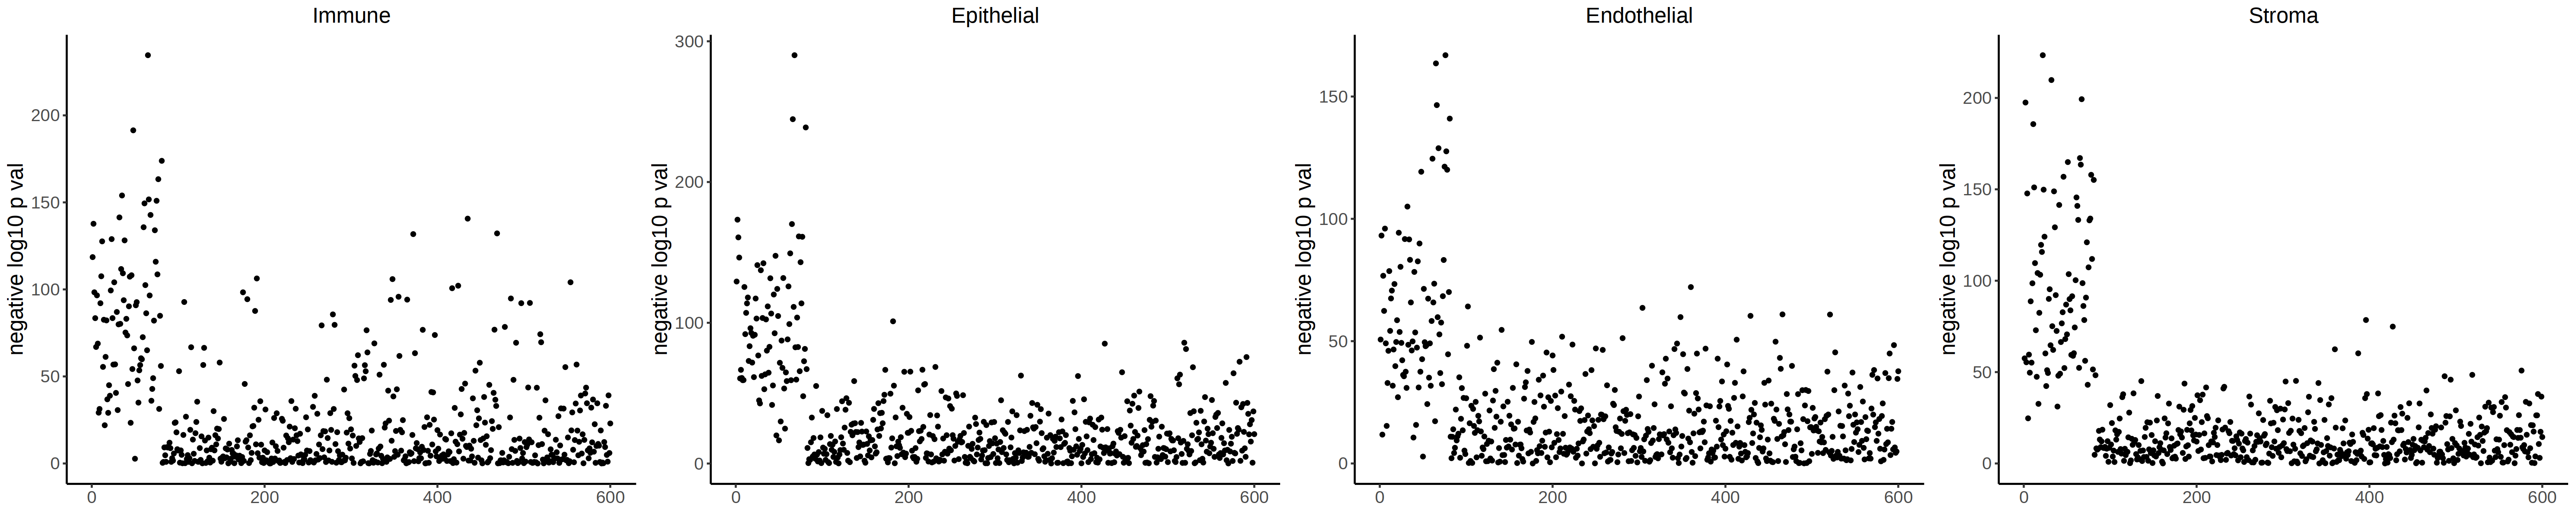

In [12]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(base.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

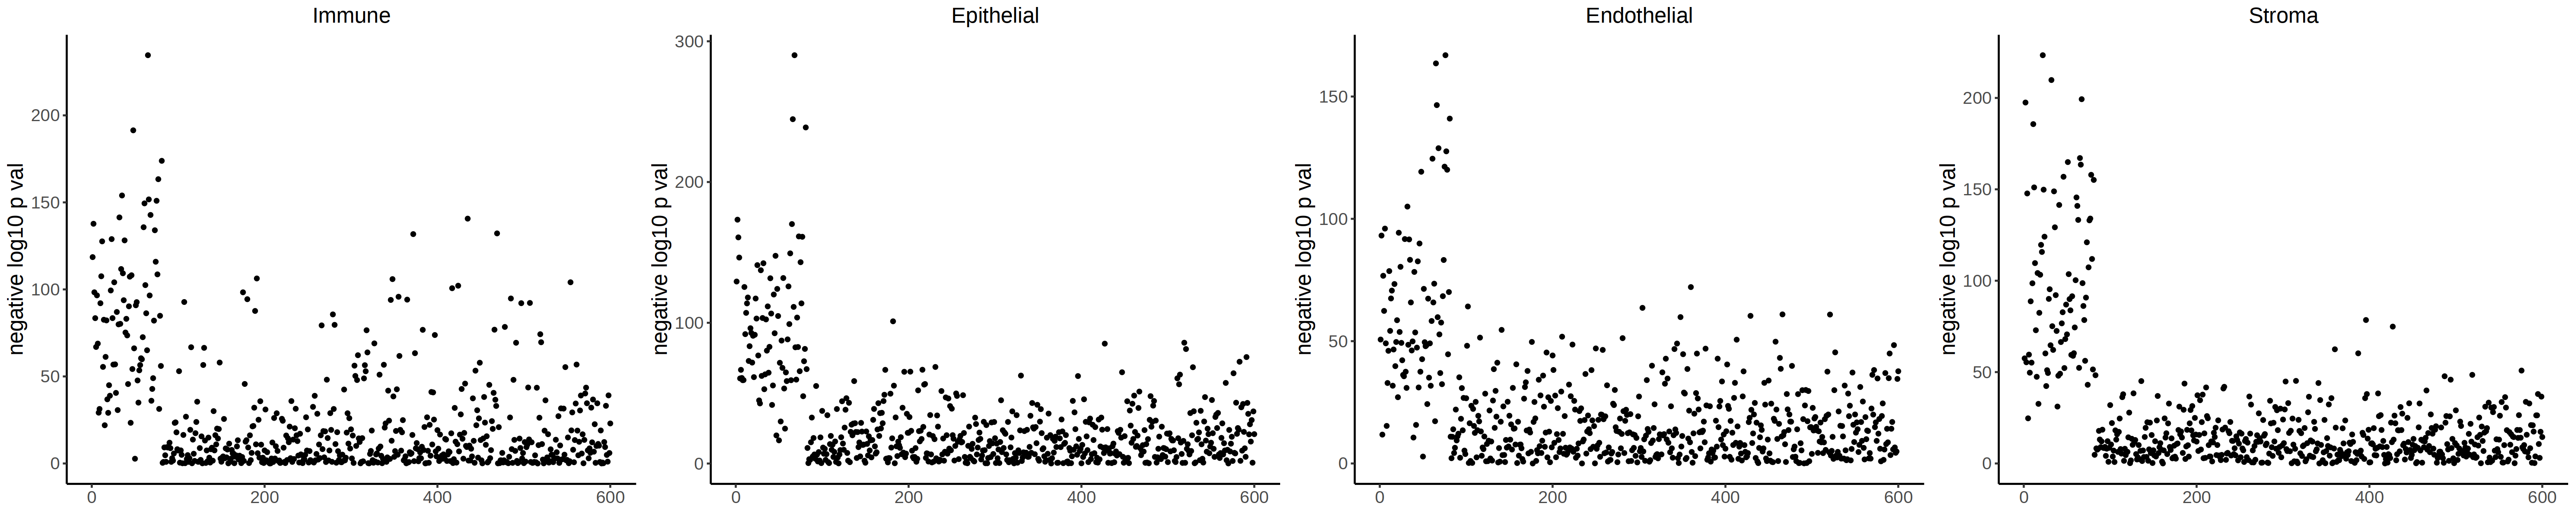

In [13]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(cibersortx.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

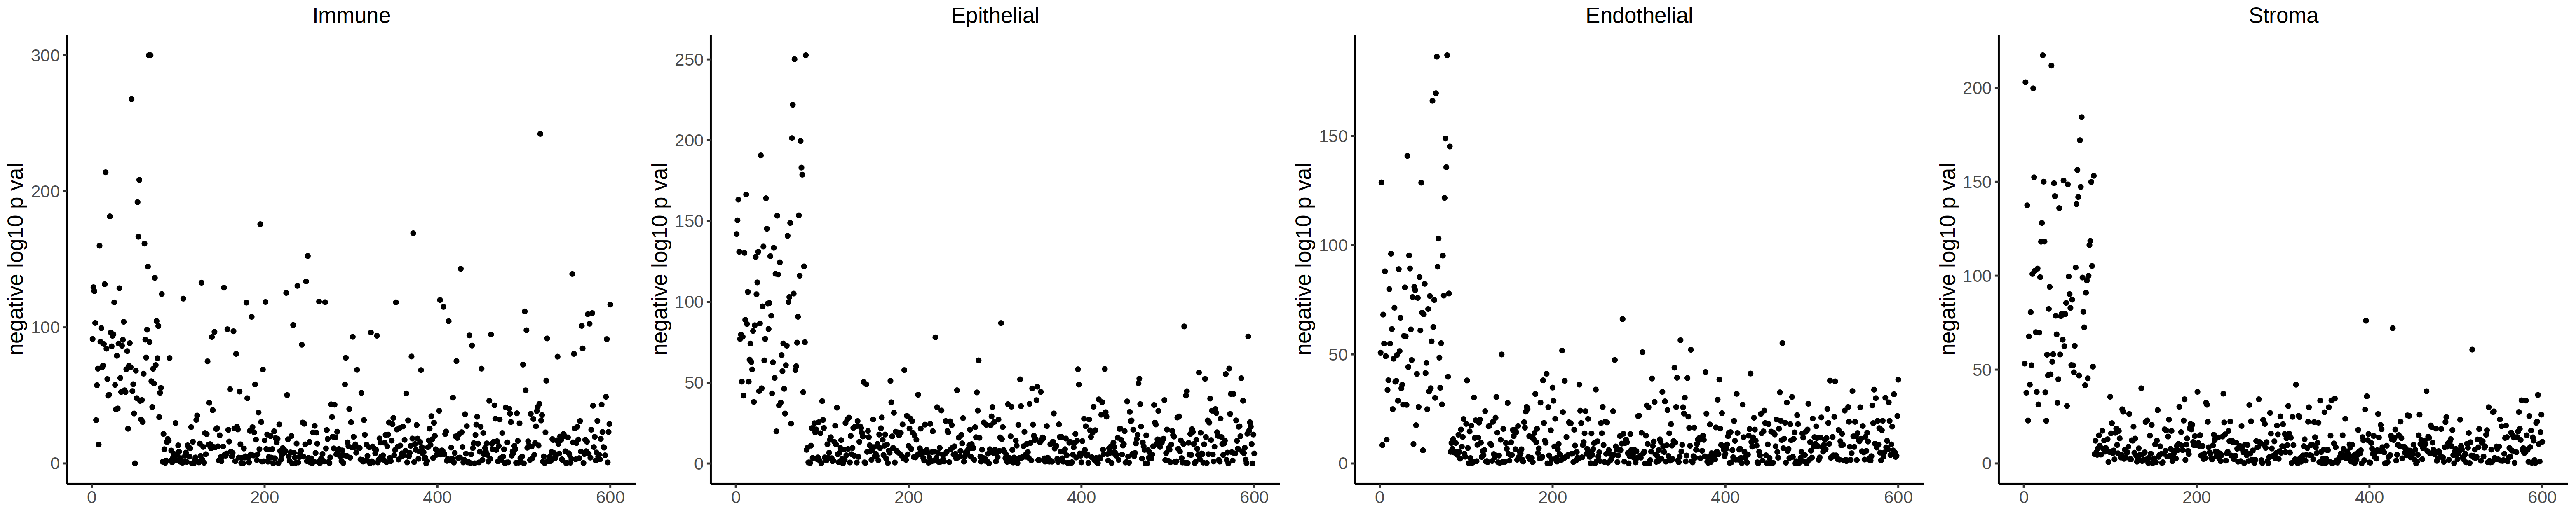

In [14]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tca.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

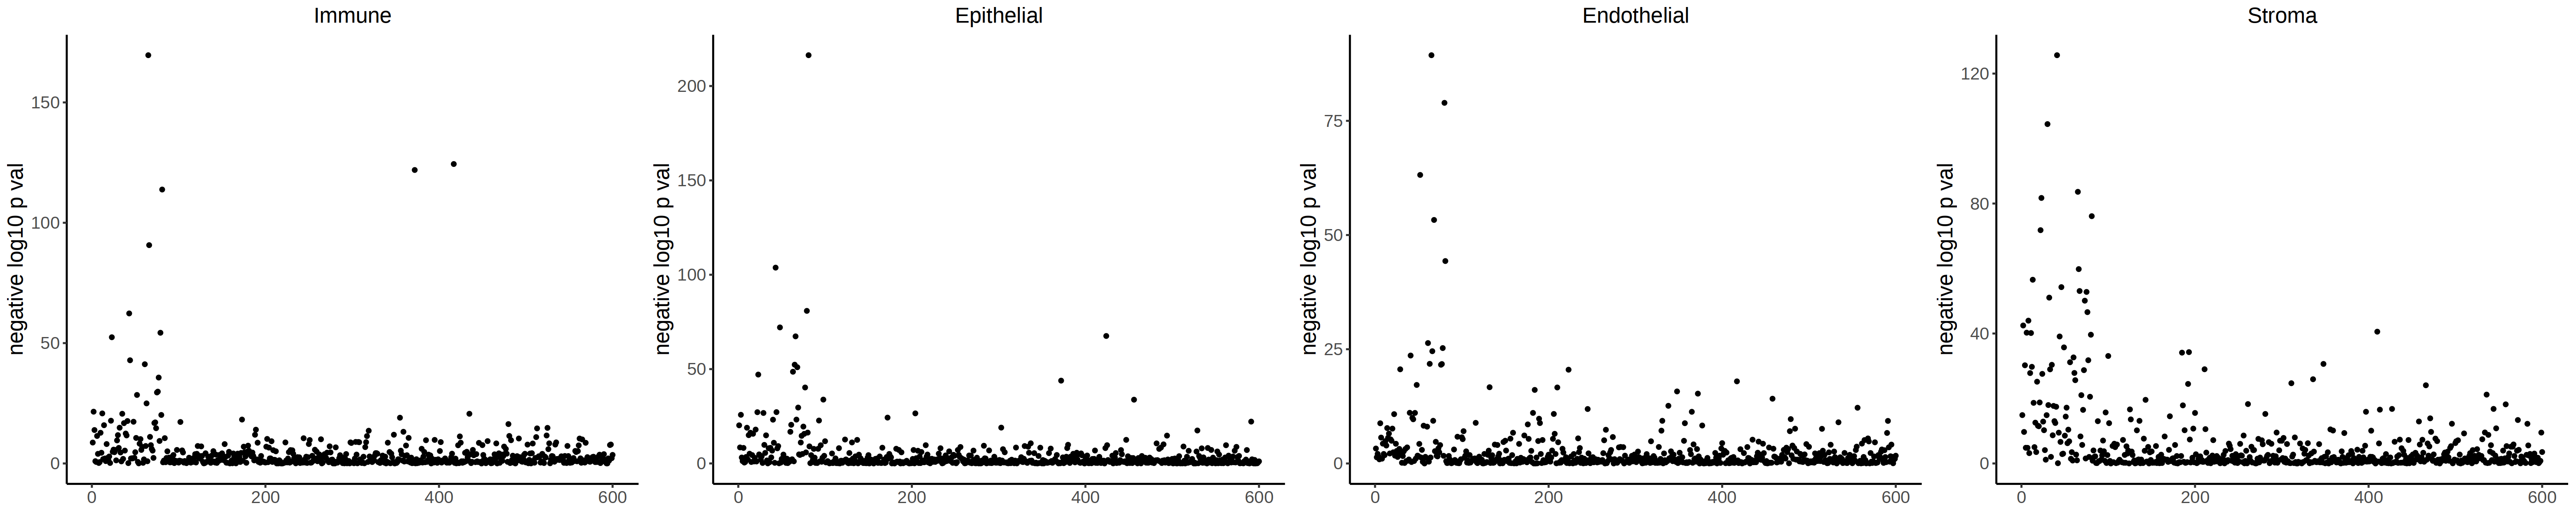

In [15]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tcax.log.p.vals.mats, "bulk", source.ids = colnames(sim.data.list[[1]]$W))

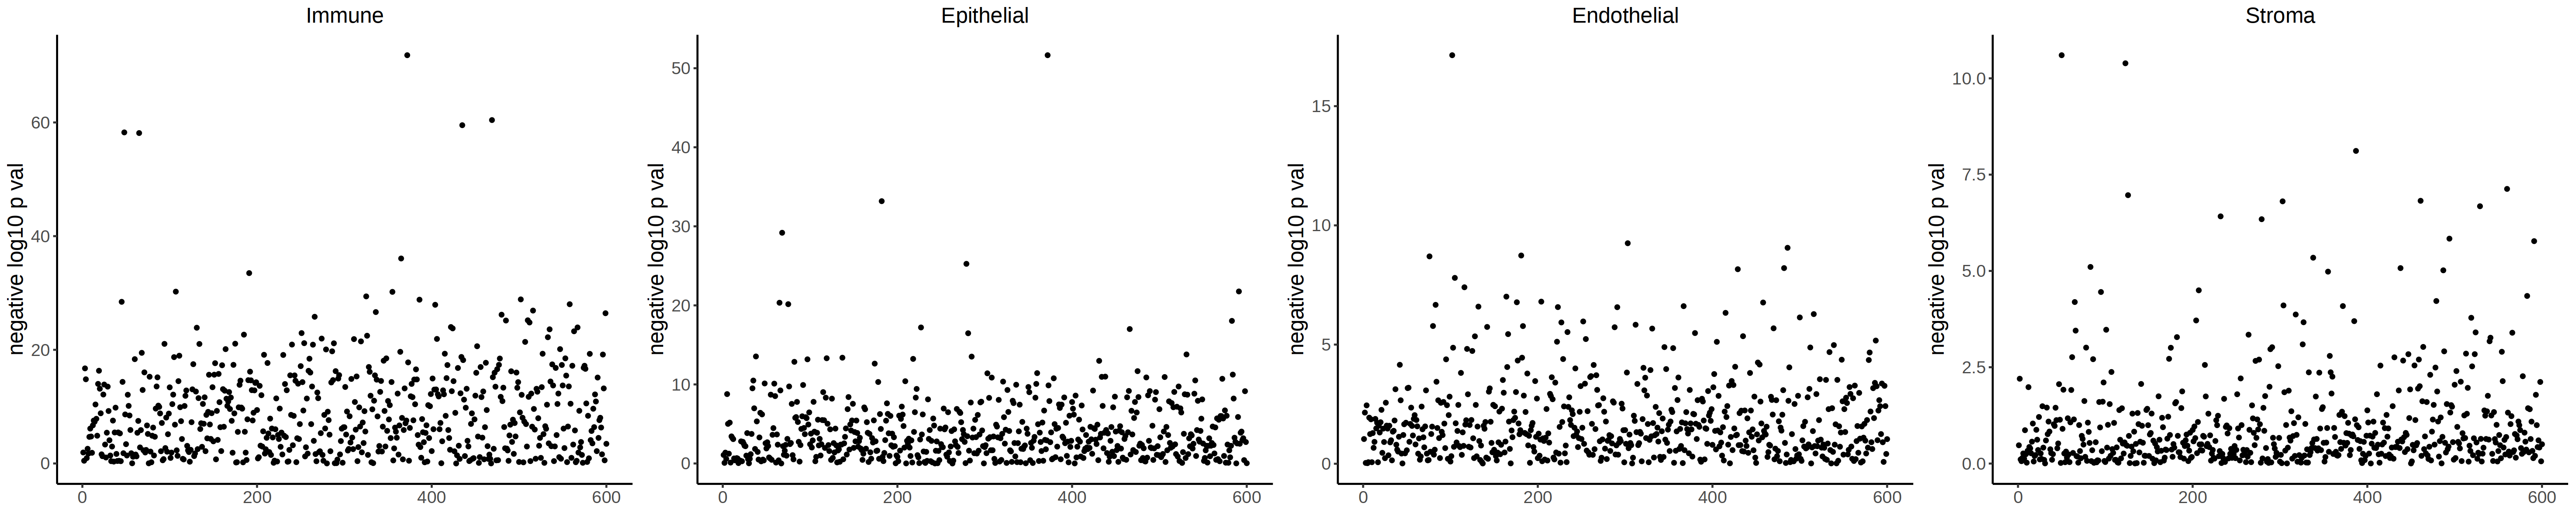

In [16]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(base.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

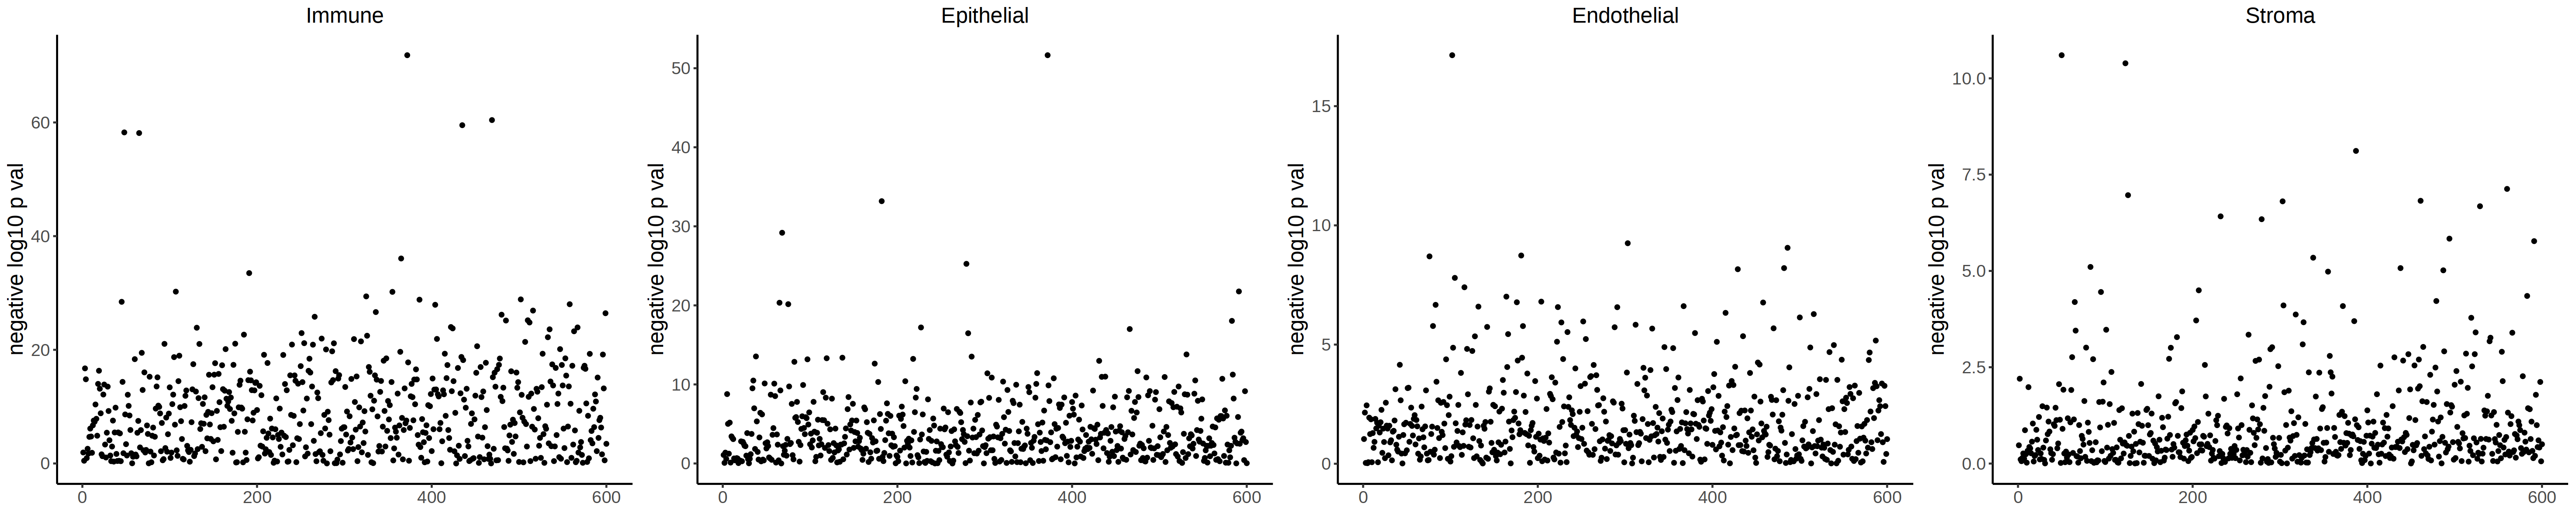

In [17]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(cibersortx.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

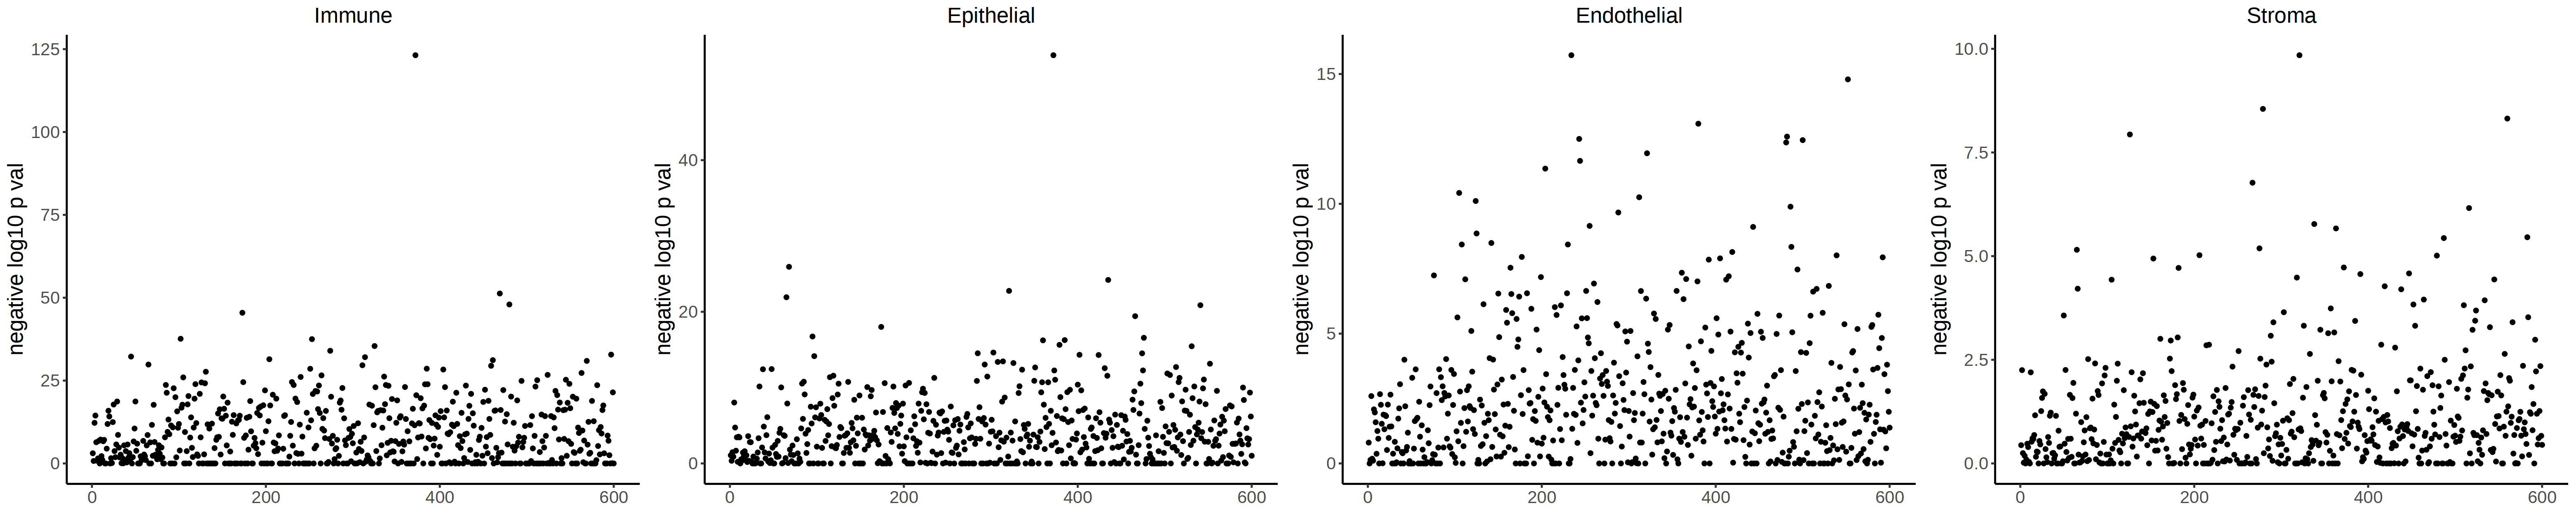

In [18]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tca.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

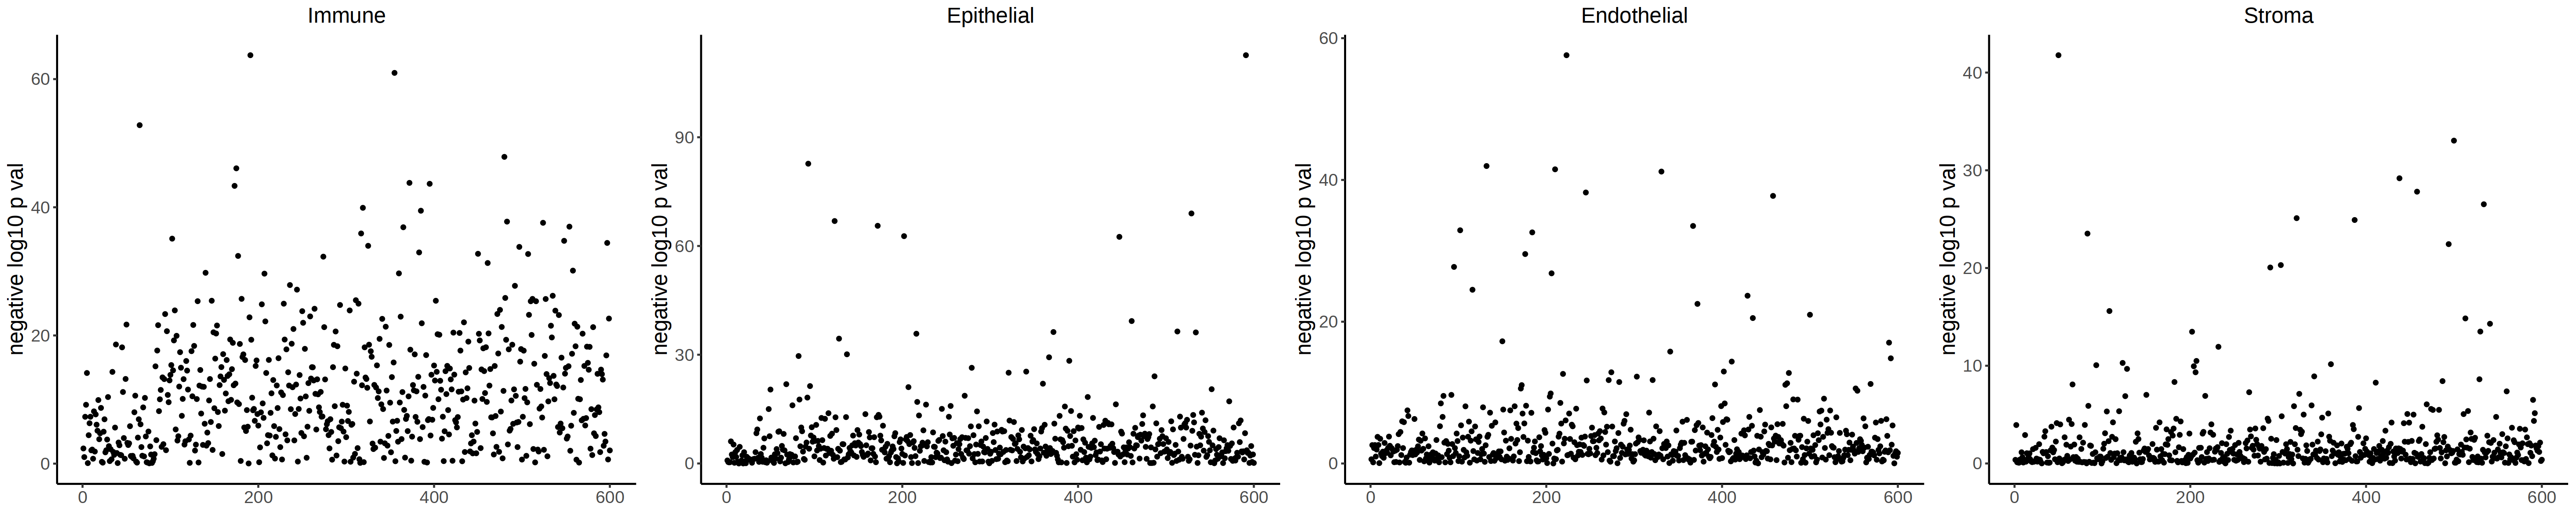

In [19]:
options(repr.plot.width = 25, repr.plot.height = 5, repr.plot.res = 250)
manplot(tcax.log.p.vals.mats, "Z.hat", source.ids = colnames(sim.data.list[[1]]$W))

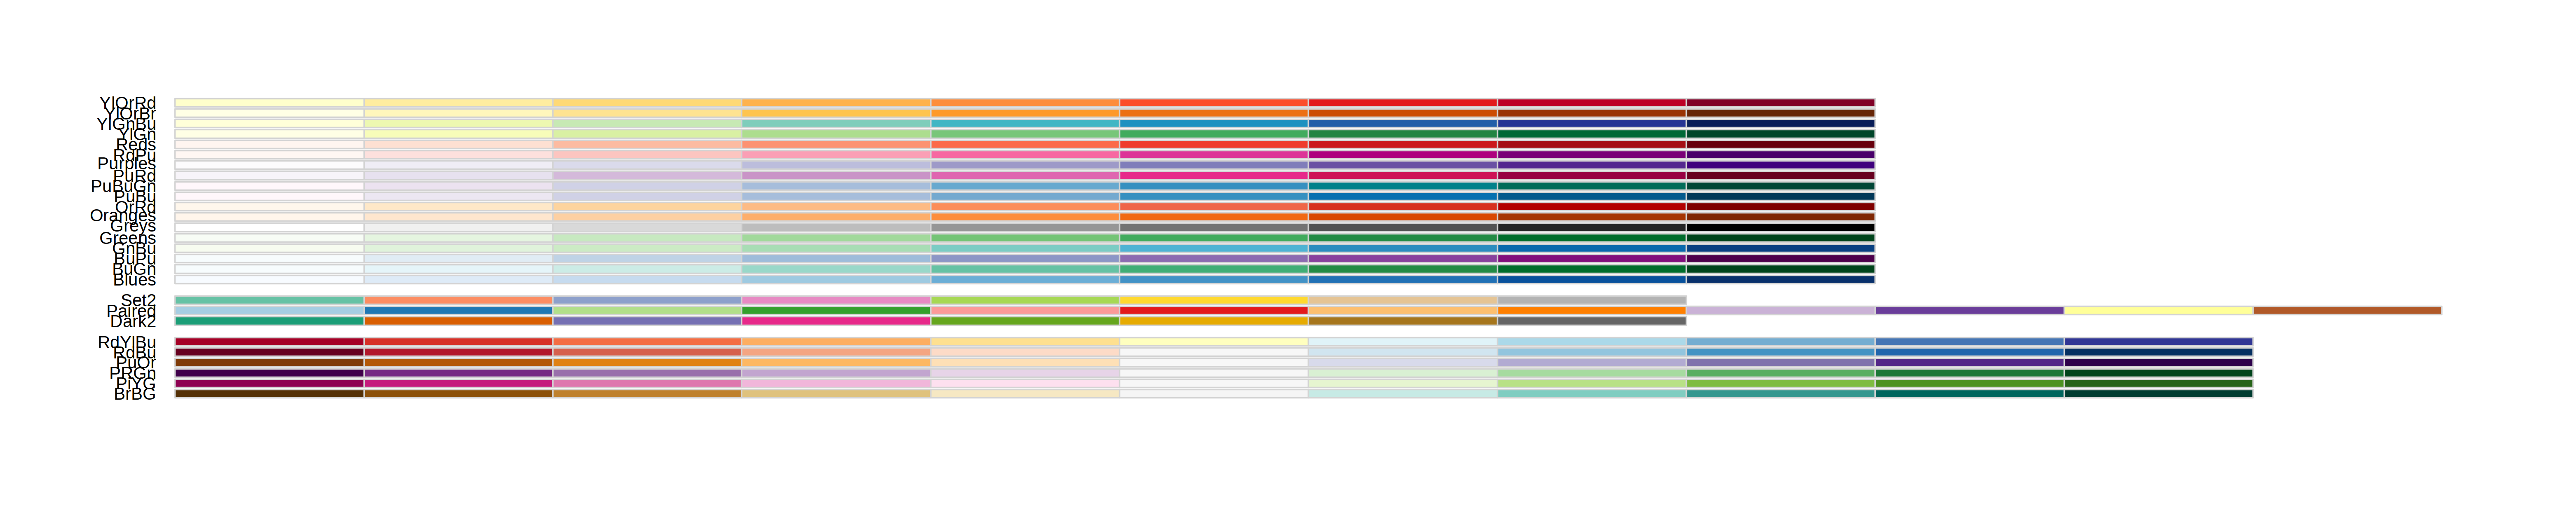

In [20]:

########################################### Color code ################################################
library(RColorBrewer)


display.brewer.all(colorblindFriendly = TRUE)
base.color = brewer.pal(n = 8, name = "Set2")[8]
bulk.color = brewer.pal(n = 8, name = "Set2")[7]
cibersortx.color = brewer.pal(n = 8, name = "Set2")[5]
tca.color  = brewer.pal(n = 8, name = "Set2")[3]
tcax.color = brewer.pal(n = 8, name = "Set2")[4]


In [21]:
source.ids

[1] "Immune"      "Epithelial"  "Endothelial" "Stroma"

In [22]:
sub.titles = source.ids
dot.alpha = 0.75
dot.size  = 3
title.size = 25
lab.size = 20
xlab.text = "Bulk"
ylab.text = "Deconvolution Tensor"

In [23]:
plts = list()
for (h in 1:k){
    source.id = source.ids[h]
    plot.df = data.frame(x = c(base.log.p.vals.mats[[source.id]][,"bulk"],
                               cibersortx.log.p.vals.mats[[source.id]][,"bulk"],
                               tca.log.p.vals.mats[[source.id]][,"bulk"],
                               tcax.log.p.vals.mats[[source.id]][,"bulk"]),
                         y = c(base.log.p.vals.mats[[source.id]][,"Z.hat"],
                               cibersortx.log.p.vals.mats[[source.id]][,"Z.hat"],
                               tca.log.p.vals.mats[[source.id]][,"Z.hat"],
                               tcax.log.p.vals.mats[[source.id]][,"Z.hat"]),
                         method = c(rep("Baseline", m), rep("CIBERSORTx", m),
                                    rep("TCA", m), rep("TCAx", m)))
    
    plot.df$method = factor(plot.df$method, levels = c("Baseline","CIBERSORTx", "TCA","TCAx"))

    print(colnames(plot.df))
    
    model.vis.thr = max(quantile(as.vector(plot.df$x), 0.95, na.rm = T), 
                        quantile(as.vector(plot.df$y), 0.95, na.rm = T))

    model.fit.thr = min(quantile(as.vector(plot.df$x), 0.95, na.rm = T), 
                        quantile(as.vector(plot.df$y), 0.95, na.rm = T))

    print(model.fit.thr)
    print(sum(plot.df[,c("x", "y")], na.rm = T))
    
    if(sum(plot.df[,c("x", "y")], na.rm = T)>300){
        plot.df[,c("x", "y")][plot.df[,c("x", "y")]>300] = 300;
        print("super small pvals are set to -log10 300")
    }


    g = ggplot(plot.df, aes(x = x, y = y, fill = method, color = method)) +
        geom_point(alpha = dot.alpha, size = dot.size) + 
        geom_smooth(method = "lm",
                    formula = y ~ 0 + x, 
                    data=subset(plot.df, x < model.fit.thr, y < model.fit.thr),
                    fullrange = T) + 
        scale_colour_manual(values = c(base.color, cibersortx.color, tca.color, tcax.color), name=NULL) + 
        scale_fill_manual(values = c(base.color, cibersortx.color, tca.color, tcax.color), name=NULL) + 
        geom_abline(slope=1, colour= "black", linetype = "dashed") + 
        coord_cartesian(xlim = c(0, model.vis.thr),ylim = c(0, model.vis.thr))+
    
        theme_classic() +
        ggtitle(paste0(sub.titles[h]," (", round(colMeans(sim.data$W)[h], 2) * 100, "%)")) +  
        theme(plot.title = element_text(hjust = 0.5, size=title.size)) + 
    
        xlab(parse(text = paste0("\'",xlab.text,"\'~", expression(-log[10](P))))) +
        ylab(parse(text = paste0("\'",ylab.text,"\'~", expression(-log[10](P))))) +
        theme(axis.title.x = element_text(size = lab.size)) + 
        theme(axis.text.x  = element_text(size = lab.size)) + 
        theme(axis.title.y = element_text(size = lab.size)) +
        theme(axis.text.y  = element_text(size = lab.size))  +
        theme(legend.text=element_text(size= lab.size))

    if(h!= k){g = g + theme(legend.position = "none")}
    plts[[h]] = g
}


[1] "x"      "y"      "method"
[1] 24.86216
[1] Inf
[1] "super small pvals are set to -log10 300"
[1] "x"      "y"      "method"
[1] 12.79722
[1] 64502.63
[1] "super small pvals are set to -log10 300"
[1] "x"      "y"      "method"
[1] 7.150077
[1] 45398.74
[1] "super small pvals are set to -log10 300"
[1] "x"      "y"      "method"
[1] 4.362559
[1] 49725.31
[1] "super small pvals are set to -log10 300"


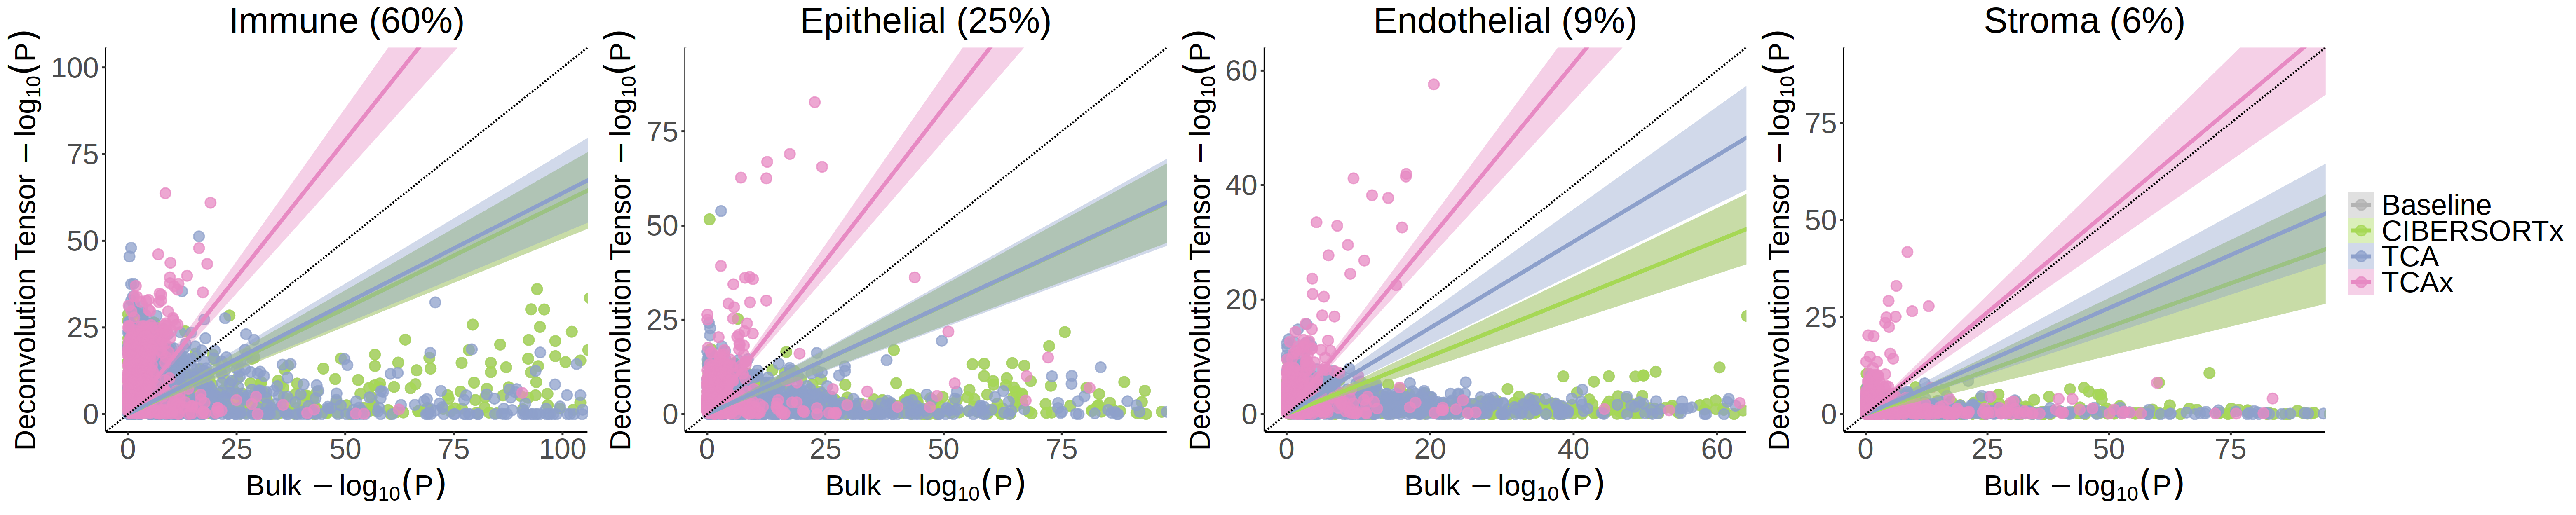

In [24]:
g = egg::ggarrange(plots = plts, align = "h", widths = rep(1, k)) 

# pdf(file.path(project.dir,"Orthognal/figure",paste0("orthognal.h2h.",version,".pdf")), height = 5, width = 22, onefile=FALSE)
# g
# dev.off()